<a href="https://colab.research.google.com/github/adag21044/US-Voter-Analysis/blob/main/US_Voter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib


In [ ]:
# ===========================
# LOAD DATASET
# ===========================

df = pd.read_csv("ExtractedTweets.csv")

# ☢ Tweet column name
TWEET_COLUMN = "Tweet"  # Eğer sende "tweet" ise burayı değiştir

tweets = df[TWEET_COLUMN].dropna().tolist()

print(f"Loaded {len(tweets)} tweets from dataset.")

Loaded 86460 tweets from dataset.


In [ ]:
def preprocess_tweet(tweet: str) -> str:
    if pd.isna(tweet):
        return ""
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)
    tweet = re.sub(r"@\w+|#", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    return tweet


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
bert_model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
def get_bert_embedding(tweet: str) -> np.ndarray:
    tokens = tokenizer(
        tweet,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=50
    )
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).numpy().flatten()


In [ ]:
datasets = {
    (-5, 5): [
        "Public healthcare is a human right.",
        "We must tax billionaires fairly.",
        "Workers deserve better wages."
    ],
    (5, -5): [
        "The government should be as small as possible.",
        "Lower taxes help economic growth.",
        "Personal freedom is the foundation of society."
    ]
}


In [ ]:
X, y = [], []

for (x_coord, y_coord), tweets in datasets.items():
    for tweet in tweets:
        emb = get_bert_embedding(preprocess_tweet(tweet))
        X.append(emb)
        y.append((x_coord, y_coord))


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    max_iter=800,
    early_stopping=False,
    random_state=42
)


mlp.fit(X_scaled, y)


MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=800, random_state=42)

In [ ]:
my_tweet = "The government is getting too big and controlling everything."
cleaned = preprocess_tweet(my_tweet)
embedding = get_bert_embedding(cleaned).reshape(1, -1)
embedding = scaler.transform(embedding)
predicted_point = mlp.predict(embedding)[0]


In [ ]:
DEMOCRAT_ANCHOR = np.array([-5, 5])
REPUBLICAN_ANCHOR = np.array([5, -5])

def estimate_ideological_leaning(point: np.ndarray) -> dict:
    dist_dem = np.linalg.norm(point - DEMOCRAT_ANCHOR)
    dist_rep = np.linalg.norm(point - REPUBLICAN_ANCHOR)

    if dist_dem < dist_rep:
        leaning = "Democrat-leaning"
        confidence = dist_rep / (dist_dem + dist_rep)
    else:
        leaning = "Republican-leaning"
        confidence = dist_dem / (dist_dem + dist_rep)
    return {"leaning": leaning, "confidence": confidence, "distances": {"democrat": dist_dem, "republican": dist_rep}}

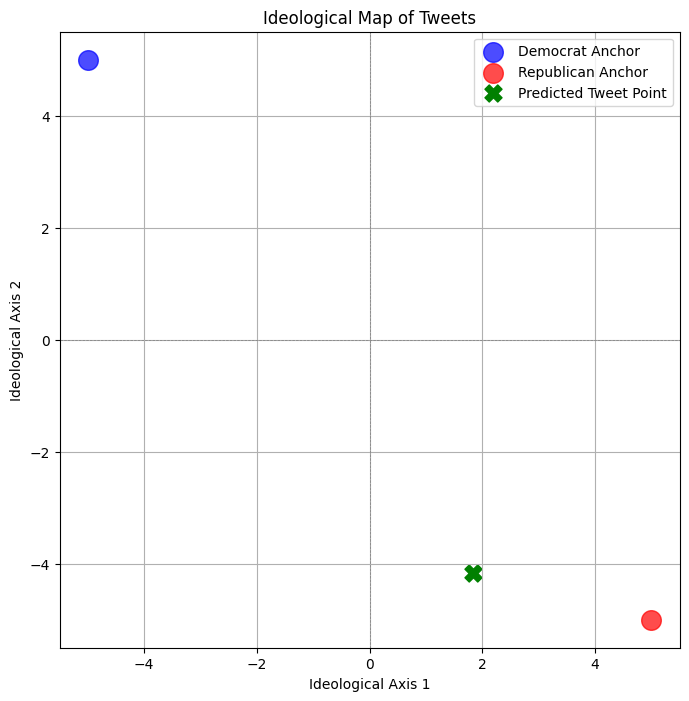

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(-5, 5, color='blue', s=200, label='Democrat Anchor', alpha=0.7)
plt.scatter(5, -5, color='red', s=200, label='Republican Anchor', alpha=0.7)
plt.scatter(predicted_point[0], predicted_point[1], color='green', s=150, label='Predicted Tweet Point', marker='X')

plt.xlabel('Ideological Axis 1')
plt.ylabel('Ideological Axis 2')
plt.title('Ideological Map of Tweets')
plt.grid(True)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
joblib.dump(mlp, "mlp_model.joblib")
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']